# Drive Mount

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Required Library

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import random
import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import plot_model
from sklearn.metrics import classification_report
from collections import Counter
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

from keras import Model, layers
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Number of images in the train set :  4083
Number of images in the test set ;  511
Number of images in prediction set :  6


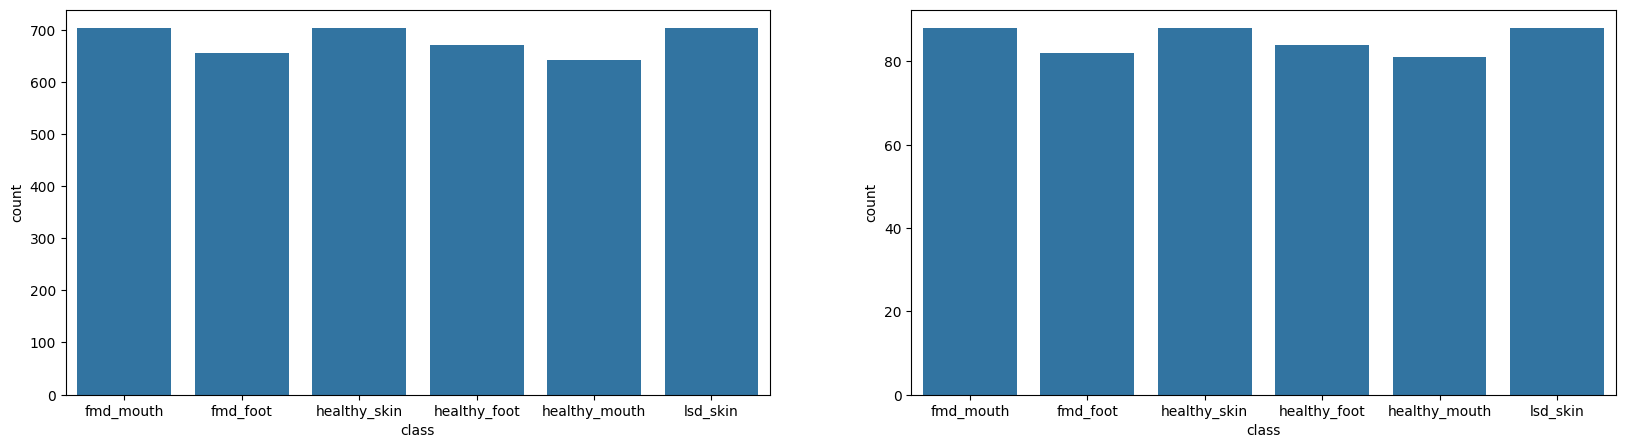

In [4]:
root_path = '/content/drive/MyDrive/Capstone/finalized_data'
train_pred_test_folders = os.listdir(root_path)

seg_train_folders = '/content/drive/MyDrive/Capstone/Dataset/train/' #one more seg_train folder within
seg_test_folders = '/content/drive/MyDrive/Capstone/Dataset/test/'
seg_pred_folders = '/content/drive/MyDrive/Capstone/Dataset/val/'
quantity_tr = {}
quantity_te = {}
for folder in os.listdir(seg_train_folders):
    quantity_tr[folder] = len(os.listdir(seg_train_folders+folder))

for folder in os.listdir(seg_test_folders):
    quantity_te[folder] = len(os.listdir(seg_test_folders+folder))

quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])

figure, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Number of images in the train set : ", sum(quantity_tr.values()))
print("Number of images in the test set ; ",sum(quantity_te.values()))
number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in prediction set : ",number_of_images_in_prediction_set)

plt.show()

In [5]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:
    hist_df = pd.DataFrame(history.history)

    # save to json:
    hist_json_file = model_name+'_history.json'
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv:
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']


    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()

def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()

def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [6]:
train_datagen = ImageDataGenerator( rescale = 1.0/255.,shear_range=0.2,zoom_range=0.2)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance.
train_generator = train_datagen.flow_from_directory(seg_train_folders,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

validation_datagen = ImageDataGenerator(rescale = 1.0/255.) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(seg_test_folders, shuffle=True, batch_size=1, class_mode='categorical', target_size=(150, 150))

Found 4083 images belonging to 6 classes.
Found 511 images belonging to 6 classes.


In [7]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'fmd_foot': 0, 'fmd_mouth': 1, 'healthy_foot': 2, 'healthy_mouth': 3, 'healthy_skin': 4, 'lsd_skin': 5}
{0: 'fmd_foot', 1: 'fmd_mouth', 2: 'healthy_foot', 3: 'healthy_mouth', 4: 'healthy_skin', 5: 'lsd_skin'}


In [8]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(seg_train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(seg_train_folders)):
        image_ids = os.listdir(os.path.join(seg_train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:

            display = plt.imread(os.path.join(seg_train_folders,folder,image_ids[j]))
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(inception_best_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

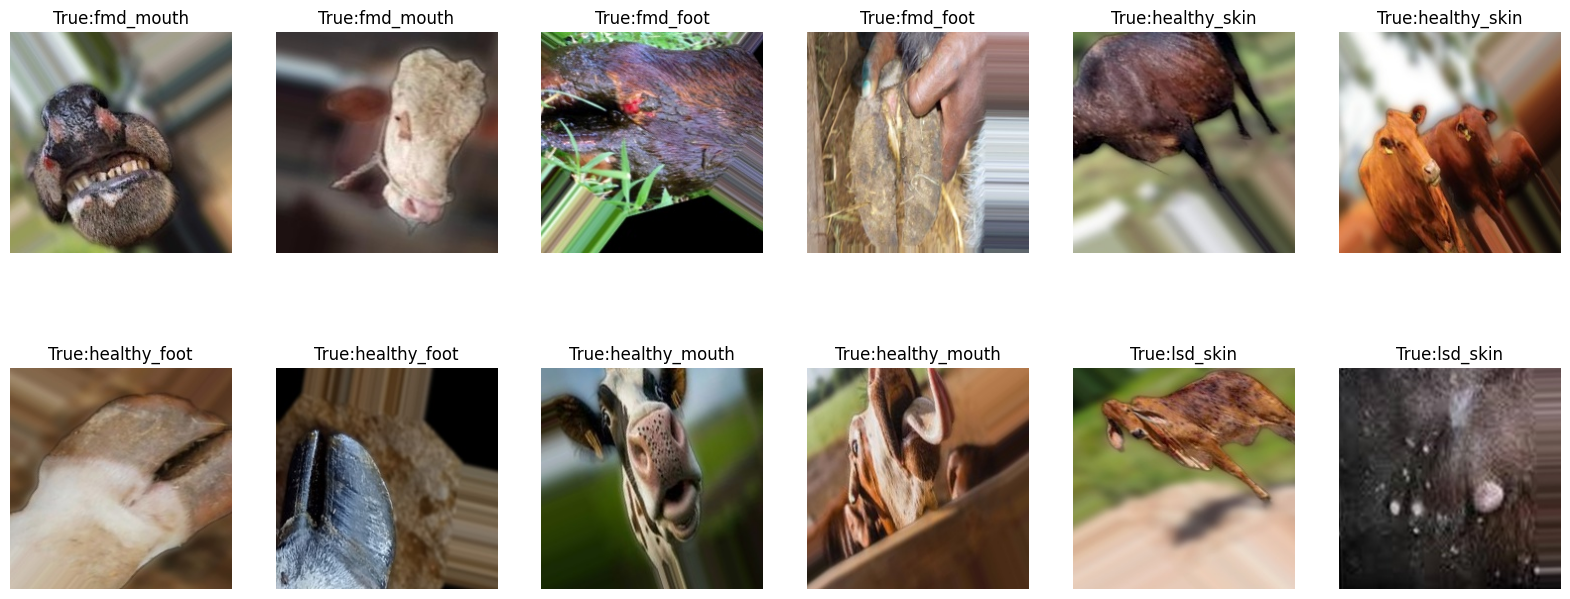

In [9]:
show_few_images(2)


In [10]:
tf.keras.backend.clear_session()

# epoch config
#benchmark_epoch = 60
vgg_epoch = 80
resnet_epoch = 80
inception_epoch = 80

In [11]:
#random architecture
benchmark_model = Sequential()
# Input here is 4D array (batchsize, height, width, channels) - we have already created the train_generator with batch size 32
# 32 Images of size each 150x150 with 3 color channels will be input into this layer
benchmark_model.add(Conv2D(128, kernel_size=7, activation='relu', input_shape=(150,150,3)))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Conv2D(64, kernel_size=5, activation='relu'))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Flatten())
benchmark_model.add(Dense(128,activation='relu'))
benchmark_model.add(Dense(6,activation='softmax'))

benchmark_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

benchmark_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 144, 144, 128)     18944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 71, 71, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 67, 67, 64)        204864    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 128)               8

# Dropout Layer Vgg

Epoch 1/80
128/128 [==============================] - ETA: 0s - loss: 1.4274 - acc: 0.4526
Epoch 1: val_acc improved from -inf to 0.66145, saving model to vgg_16_-saved-model-01-acc-0.66.hdf5
128/128 [==============================] - 181s 1s/step - loss: 1.4274 - acc: 0.4526 - val_loss: 1.0045 - val_acc: 0.6614
Epoch 2/80


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


128/128 [==============================] - ETA: 0s - loss: 1.0060 - acc: 0.6304
Epoch 2: val_acc improved from 0.66145 to 0.71233, saving model to vgg_16_-saved-model-02-acc-0.71.hdf5
128/128 [==============================] - 42s 329ms/step - loss: 1.0060 - acc: 0.6304 - val_loss: 0.7977 - val_acc: 0.7123
Epoch 3/80
128/128 [==============================] - ETA: 0s - loss: 0.8751 - acc: 0.6728
Epoch 3: val_acc improved from 0.71233 to 0.75930, saving model to vgg_16_-saved-model-03-acc-0.76.hdf5
128/128 [==============================] - 43s 334ms/step - loss: 0.8751 - acc: 0.6728 - val_loss: 0.6906 - val_acc: 0.7593
Epoch 4/80
128/128 [==============================] - ETA: 0s - loss: 0.7851 - acc: 0.7105
Epoch 4: val_acc improved from 0.75930 to 0.78278, saving model to vgg_16_-saved-model-04-acc-0.78.hdf5
128/128 [==============================] - 46s 363ms/step - loss: 0.7851 - acc: 0.7105 - val_loss: 0.6445 - val_acc: 0.7828
Epoch 5/80
128/128 [==============================] - 

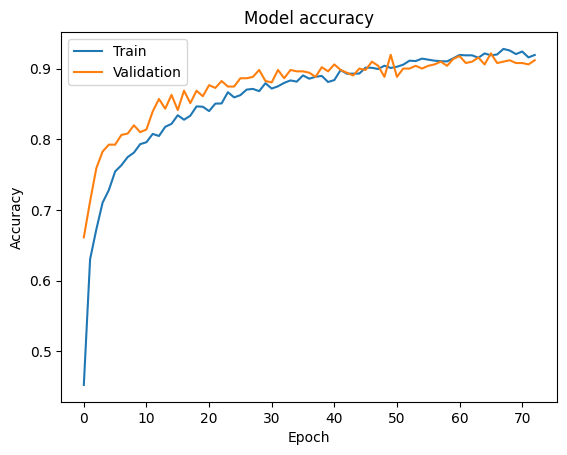

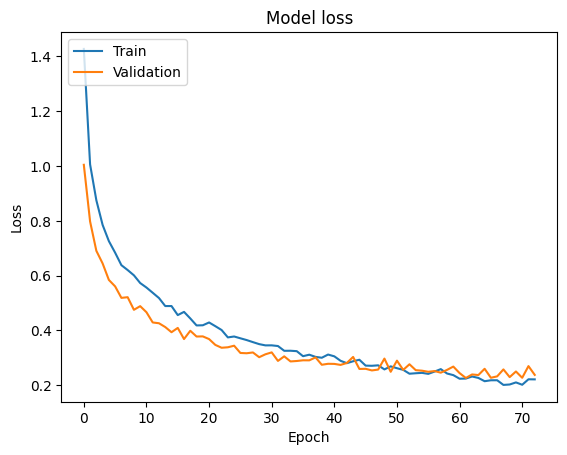

In [16]:
from tensorflow.keras.layers import Dropout

vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(150,150,3))
for layers in vgg16_model.layers:
    layers.trainable = False

last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation='relu')(vgg_x)
vgg_x = Dropout(0.5)(vgg_x)  # Add dropout with a dropout rate of 0.5
vgg_x = Dense(6, activation='softmax')(vgg_x)

vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Rest of your code remains unchanged
number_of_epochs = vgg_epoch
vgg16_filepath = 'vgg_16_' + '-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
vgg16_history = vgg16_final_model.fit(train_generator, epochs=number_of_epochs, validation_data=validation_generator, callbacks=[vgg_checkpoint, vgg_early_stopping], verbose=1)

# Plot training & validation accuracy values
plt.plot(vgg16_history.history['acc'])
plt.plot(vgg16_history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(vgg16_history.history['loss'])
plt.plot(vgg16_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Dropout Layer Resnet50

94765736/94765736 [==============================] - 1s 0us/step


Epoch 1/80
128/128 [==============================] - ETA: 0s - loss: 1.4862 - acc: 0.5836
Epoch 1: val_acc improved from -inf to 0.17221, saving model to resnet50-saved-model-01-val_acc-0.17.hdf5
128/128 [==============================] - 72s 406ms/step - loss: 1.4862 - acc: 0.5836 - val_loss: 3.7668 - val_acc: 0.1722 - lr: 0.0100
Epoch 2/80
128/128 [==============================] - ETA: 0s - loss: 0.6226 - acc: 0.7989
Epoch 2: val_acc did not improve from 0.17221
128/128 [==============================] - 48s 368ms/step - loss: 0.6226 - acc: 0.7989 - val_loss: 1.8671 - val_acc: 0.1546 - lr: 0.0100
Epoch 3/80
128/128 [==============================] - ETA: 0s - loss: 0.3431 - acc: 0.8893
Epoch 3: val_acc did not improve from 0.17221
128/128 [==============================] - 52s 405ms/step - loss: 0.3431 - acc: 0.8893 - val_loss: 5.0228 - val_acc: 0.1722 - lr: 0.0100
Epoch 4/80
128/128 [==============================] - ETA: 0s - loss: 0.2185 - acc: 0.9300
Epoch 4: val_acc did not im

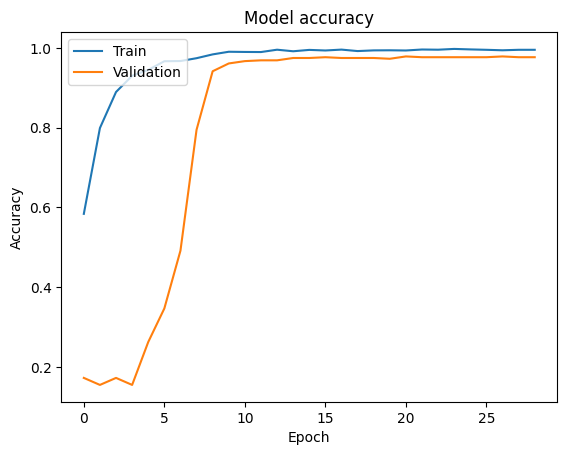

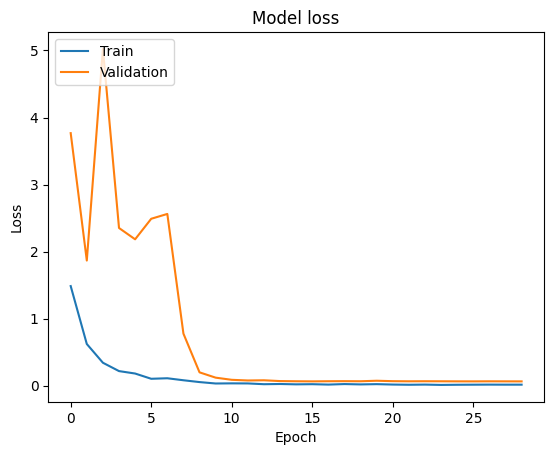

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Load pre-trained ResNet50 model
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3), classes=6)

# Make the layers trainable
for layer in ResNet50_model.layers:
    layer.trainable = True

# Define the new layers for your model
resnet50_x = Flatten()(ResNet50_model.output)
resnet50_x = Dense(256, activation='relu')(resnet50_x)
resnet50_x = Dropout(0.5)(resnet50_x)  # Add dropout with a dropout rate of 0.5
resnet50_x = Dense(6, activation='softmax')(resnet50_x)

# Create the final model
resnet50_x_final_model = Model(inputs=ResNet50_model.input, outputs=resnet50_x)

# Compile the model with your optimizer and loss function
opt = SGD(lr=0.01, momentum=0.7)
resnet50_x_final_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

# Define callbacks
number_of_epochs = resnet_epoch
resnet_filepath = 'resnet50' + '-saved-model-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5'
resnet_checkpoint = ModelCheckpoint(resnet_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
resnet_early_stopping = EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callback_list = [resnet_checkpoint, resnet_early_stopping, reduce_lr]

# Train the model
resnet50_history = resnet50_x_final_model.fit(train_generator, epochs=number_of_epochs,
                                              validation_data=validation_generator,
                                              callbacks=callback_list, verbose=1)

# Plot training & validation accuracy values
plt.plot(resnet50_history.history['acc'])
plt.plot(resnet50_history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(resnet50_history.history['loss'])
plt.plot(resnet50_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Dropour Layer Inceptionv3

87910968/87910968 [==============================] - 0s 0us/step


Epoch 1/80
128/128 [==============================] - ETA: 0s - loss: 1.0974 - accuracy: 0.7392

128/128 [==============================] - 58s 374ms/step - loss: 1.0974 - accuracy: 0.7392 - val_loss: 0.4038 - val_accuracy: 0.8728
Epoch 2/80
128/128 [==============================] - ETA: 0s - loss: 0.2812 - accuracy: 0.9150

128/128 [==============================] - 45s 353ms/step - loss: 0.2812 - accuracy: 0.9150 - val_loss: 0.1879 - val_accuracy: 0.9315
Epoch 3/80
128/128 [==============================] - ETA: 0s - loss: 0.1507 - accuracy: 0.9520

128/128 [==============================] - 45s 348ms/step - loss: 0.1507 - accuracy: 0.9520 - val_loss: 0.1405 - val_accuracy: 0.9609
Epoch 4/80
128/128 [==============================] - ETA: 0s - loss: 0.1188 - accuracy: 0.9650

128/128 [==============================] - 45s 355ms/step - loss: 0.1188 - accuracy: 0.9650 - val_loss: 0.1907 - val_accuracy: 0.9472
Epoch 5/80
128/128 [==============================] - ETA: 0s - loss: 0.0949 - accuracy: 0.9718

128/128 [==============================] - 45s 351ms/step - loss: 0.0949 - accuracy: 0.9718 - val_loss: 0.2124 - val_accuracy: 0.9569
Epoch 6/80
128/128 [==============================] - ETA: 0s - loss: 0.0710 - accuracy: 0.9792

128/128 [==============================] - 45s 355ms/step - loss: 0.0710 - accuracy: 0.9792 - val_loss: 0.1608 - val_accuracy: 0.9609
Epoch 7/80
128/128 [==============================] - ETA: 0s - loss: 0.0674 - accuracy: 0.9809

128/128 [==============================] - 44s 345ms/step - loss: 0.0674 - accuracy: 0.9809 - val_loss: 0.2223 - val_accuracy: 0.9609
Epoch 8/80
128/128 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9851

128/128 [==============================] - 48s 378ms/step - loss: 0.0536 - accuracy: 0.9851 - val_loss: 0.2177 - val_accuracy: 0.9648
Epoch 9/80
128/128 [==============================] - ETA: 0s - loss: 0.0449 - accuracy: 0.9880

128/128 [==============================] - 48s 377ms/step - loss: 0.0449 - accuracy: 0.9880 - val_loss: 0.2440 - val_accuracy: 0.9393
Epoch 10/80
128/128 [==============================] - ETA: 0s - loss: 0.0396 - accuracy: 0.9887

128/128 [==============================] - 48s 374ms/step - loss: 0.0396 - accuracy: 0.9887 - val_loss: 0.1773 - val_accuracy: 0.9589
Epoch 11/80
128/128 [==============================] - ETA: 0s - loss: 0.0242 - accuracy: 0.9929

128/128 [==============================] - 46s 363ms/step - loss: 0.0242 - accuracy: 0.9929 - val_loss: 0.1696 - val_accuracy: 0.9746
Epoch 12/80
128/128 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9922

128/128 [==============================] - 51s 396ms/step - loss: 0.0288 - accuracy: 0.9922 - val_loss: 0.2610 - val_accuracy: 0.9609
Epoch 13/80
128/128 [==============================] - ETA: 0s - loss: 0.0263 - accuracy: 0.9917

128/128 [==============================] - 49s 382ms/step - loss: 0.0263 - accuracy: 0.9917 - val_loss: 0.1540 - val_accuracy: 0.9746
Epoch 14/80
128/128 [==============================] - ETA: 0s - loss: 0.0319 - accuracy: 0.9907

128/128 [==============================] - 48s 377ms/step - loss: 0.0319 - accuracy: 0.9907 - val_loss: 0.1781 - val_accuracy: 0.9628
Epoch 15/80
128/128 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9951

128/128 [==============================] - 44s 345ms/step - loss: 0.0207 - accuracy: 0.9951 - val_loss: 0.1310 - val_accuracy: 0.9706
Epoch 16/80
128/128 [==============================] - ETA: 0s - loss: 0.0324 - accuracy: 0.9904

128/128 [==============================] - 45s 351ms/step - loss: 0.0324 - accuracy: 0.9904 - val_loss: 0.1606 - val_accuracy: 0.9687
Epoch 17/80
128/128 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.9941

128/128 [==============================] - 44s 347ms/step - loss: 0.0206 - accuracy: 0.9941 - val_loss: 0.1509 - val_accuracy: 0.9687
Epoch 18/80
128/128 [==============================] - ETA: 0s - loss: 0.0294 - accuracy: 0.9917

128/128 [==============================] - 45s 353ms/step - loss: 0.0294 - accuracy: 0.9917 - val_loss: 0.1438 - val_accuracy: 0.9628
Epoch 19/80
128/128 [==============================] - ETA: 0s - loss: 0.0215 - accuracy: 0.9944

128/128 [==============================] - 44s 347ms/step - loss: 0.0215 - accuracy: 0.9944 - val_loss: 0.0841 - val_accuracy: 0.9804
Epoch 20/80
128/128 [==============================] - ETA: 0s - loss: 0.0172 - accuracy: 0.9963

128/128 [==============================] - 50s 392ms/step - loss: 0.0172 - accuracy: 0.9963 - val_loss: 0.1355 - val_accuracy: 0.9687
Epoch 21/80
128/128 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9988

128/128 [==============================] - 50s 389ms/step - loss: 0.0046 - accuracy: 0.9988 - val_loss: 0.1178 - val_accuracy: 0.9746
Epoch 22/80
128/128 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9971

128/128 [==============================] - 46s 360ms/step - loss: 0.0088 - accuracy: 0.9971 - val_loss: 0.1268 - val_accuracy: 0.9765
Epoch 23/80
128/128 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.9976

128/128 [==============================] - 49s 384ms/step - loss: 0.0055 - accuracy: 0.9976 - val_loss: 0.1463 - val_accuracy: 0.9746
Epoch 24/80
128/128 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 0.9985

128/128 [==============================] - 44s 347ms/step - loss: 0.0074 - accuracy: 0.9985 - val_loss: 0.1478 - val_accuracy: 0.9863
Epoch 25/80
128/128 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9971

128/128 [==============================] - 46s 359ms/step - loss: 0.0104 - accuracy: 0.9971 - val_loss: 0.1459 - val_accuracy: 0.9765
Epoch 26/80
128/128 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 0.9990

128/128 [==============================] - 52s 405ms/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 0.1253 - val_accuracy: 0.9843
Epoch 27/80
128/128 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.9966

128/128 [==============================] - 45s 350ms/step - loss: 0.0142 - accuracy: 0.9966 - val_loss: 0.1398 - val_accuracy: 0.9746
Epoch 28/80
128/128 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9951

128/128 [==============================] - 44s 345ms/step - loss: 0.0123 - accuracy: 0.9951 - val_loss: 0.1533 - val_accuracy: 0.9569
Epoch 29/80
128/128 [==============================] - ETA: 0s - loss: 0.0253 - accuracy: 0.9934

128/128 [==============================] - 45s 352ms/step - loss: 0.0253 - accuracy: 0.9934 - val_loss: 0.1477 - val_accuracy: 0.9687
Epoch 30/80
128/128 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.9956

128/128 [==============================] - 44s 348ms/step - loss: 0.0158 - accuracy: 0.9956 - val_loss: 0.1151 - val_accuracy: 0.9765
Epoch 31/80
128/128 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9971

128/128 [==============================] - 45s 354ms/step - loss: 0.0097 - accuracy: 0.9971 - val_loss: 0.1135 - val_accuracy: 0.9746


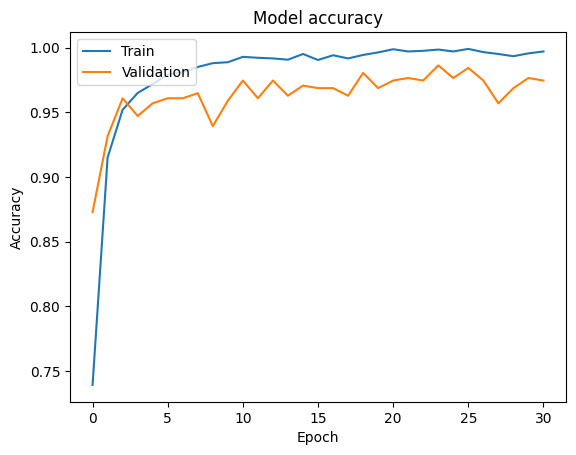

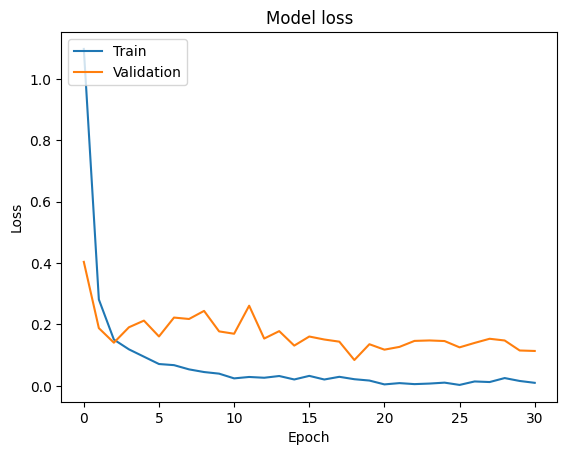

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# Load pre-trained InceptionV3 model
InceptionV3_model = InceptionV3(input_shape=(150, 150, 3), weights='imagenet', include_top=False)

# Freeze the layers up to the 249th layer
for layer in InceptionV3_model.layers[:249]:
    layer.trainable = False

# Unfreeze the layers starting from the 249th layer
for layer in InceptionV3_model.layers[249:]:
    layer.trainable = True

# Define the new layers for your model
InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(1024, activation='relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.5)(InceptionV3_x)  # Add dropout with a dropout rate of 0.5
InceptionV3_x = Dense(6, activation='softmax')(InceptionV3_x)

# Create the final model
InceptionV3_x_final_model = Model(inputs=InceptionV3_model.input, outputs=InceptionV3_x)

# Compile the model with your optimizer and loss function
InceptionV3_x_final_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
number_of_epochs = inception_epoch
inception_filepath = 'inceptionv3_' + '-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'
inception_checkpoint = ModelCheckpoint(inception_filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
inception_early_stopping = EarlyStopping(monitor='loss', patience=5)

# Train the model
inceptionv3_history = InceptionV3_x_final_model.fit(train_generator, epochs=number_of_epochs,
                                                    validation_data=validation_generator,
                                                    callbacks=[inception_checkpoint, inception_early_stopping], verbose=1)

# Plot loss values
#plot_loss_from_history(inceptionv3_history)

# Plot training & validation accuracy values
plt.plot(inceptionv3_history.history['accuracy'])  # Change 'acc' to 'accuracy'
plt.plot(inceptionv3_history.history['val_accuracy'])  # Change 'val_acc' to 'val_accuracy'
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(inceptionv3_history.history['loss'])
plt.plot(inceptionv3_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [18]:
vgg_best_model = vgg16_final_model
#resnet_best_model = resnet50_x_final_model
inception_best_model = InceptionV3_x_final_model

In [19]:

def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
combined_model_pred = []
vgg_pred = []
#resnet_pred = []
inception_pred = []
benchmark_model_pred = []
for folder in os.listdir(seg_test_folders):

    test_image_ids = os.listdir(os.path.join(seg_test_folders,folder))

    for image_id in test_image_ids[:int(len(test_image_ids))]:

        path = os.path.join(seg_test_folders,folder,image_id)

        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(150,150))
        img_normalized = img/255
        #vgg
        vgg16_image_prediction = np.argmax(vgg_best_model.predict(np.array([img_normalized])))
        vgg_pred.append(vgg16_image_prediction)

        #resnet50
        # resnet_50_image_prediction = np.argmax(resnet_best_model.predict(np.array([img_normalized])))
        # resnet_pred.append(resnet_50_image_prediction)

        #Inception
        inception_image_prediction = np.argmax(inception_best_model.predict(np.array([img_normalized])))
        inception_pred.append(inception_image_prediction)

        #benchmark
        benchmark_model_prediction = np.argmax(benchmark_model.predict(np.array([img_normalized])))
        benchmark_model_pred.append(benchmark_model_prediction)

        #giving vgg16 high priority if they all predict something different
        #image_prediction = mode([vgg16_image_prediction, resnet_50_image_prediction, inception_image_prediction])
        image_prediction = mode([vgg16_image_prediction, inception_image_prediction])
        #image_prediction = mode([resnet_50_image_prediction, inception_image_prediction])
        combined_model_pred.append(image_prediction)

1/1 [==============================] - 0s 27ms/step


In [20]:
#Confusion Matrix For VGG16

from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):

    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)

    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

    print(classification_report(true_value, model_pred, target_names = list(classes)))

Model Accuracy 0.7886497064579256
               precision    recall  f1-score   support

     fmd_foot       0.71      0.85      0.77        82
    fmd_mouth       0.85      0.69      0.76        88
 healthy_foot       0.95      0.68      0.79        84
healthy_mouth       0.87      0.85      0.86        81
 healthy_skin       0.73      0.88      0.79        88
     lsd_skin       0.73      0.78      0.75        88

     accuracy                           0.79       511
    macro avg       0.81      0.79      0.79       511
 weighted avg       0.80      0.79      0.79       511



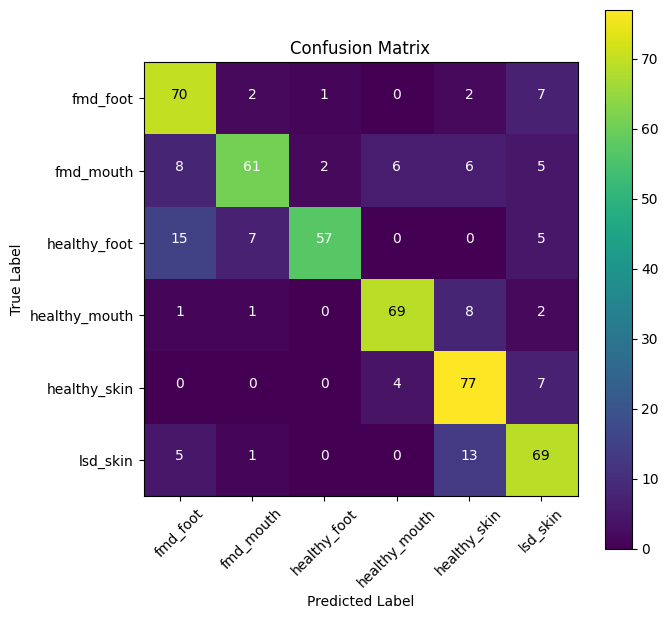

In [21]:
# VGG model classification report
clf_report(true_value, vgg_pred)

Model Accuracy 0.6908023483365949
               precision    recall  f1-score   support

     fmd_foot       0.81      0.56      0.66        82
    fmd_mouth       0.58      0.83      0.69        88
 healthy_foot       0.69      0.35      0.46        84
healthy_mouth       0.86      0.70      0.78        81
 healthy_skin       0.85      0.81      0.83        88
     lsd_skin       0.56      0.88      0.68        88

     accuracy                           0.69       511
    macro avg       0.73      0.69      0.68       511
 weighted avg       0.72      0.69      0.68       511



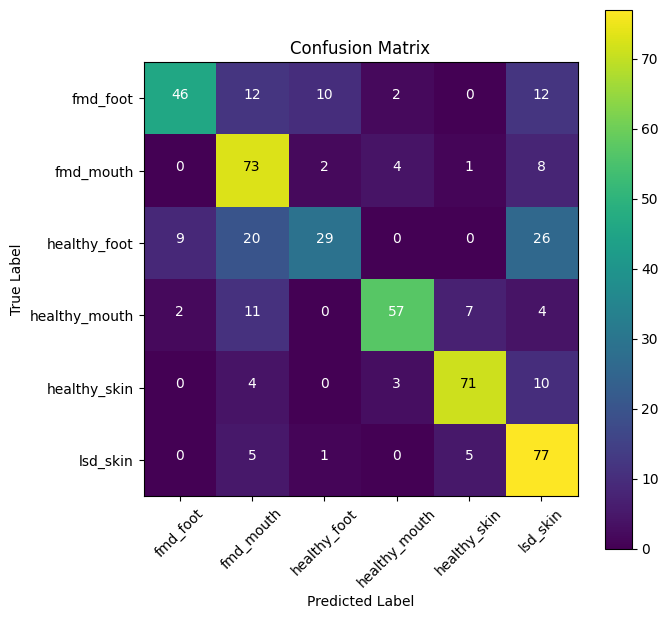

In [ ]:
# Resnet50 model classification report
clf_report(true_value, resnet_pred)

Model Accuracy 0.9295499021526419
               precision    recall  f1-score   support

     fmd_foot       0.97      0.95      0.96        82
    fmd_mouth       0.97      0.95      0.96        88
 healthy_foot       0.96      0.93      0.95        84
healthy_mouth       0.99      0.88      0.93        81
 healthy_skin       0.92      0.90      0.91        88
     lsd_skin       0.81      0.97      0.88        88

     accuracy                           0.93       511
    macro avg       0.94      0.93      0.93       511
 weighted avg       0.93      0.93      0.93       511



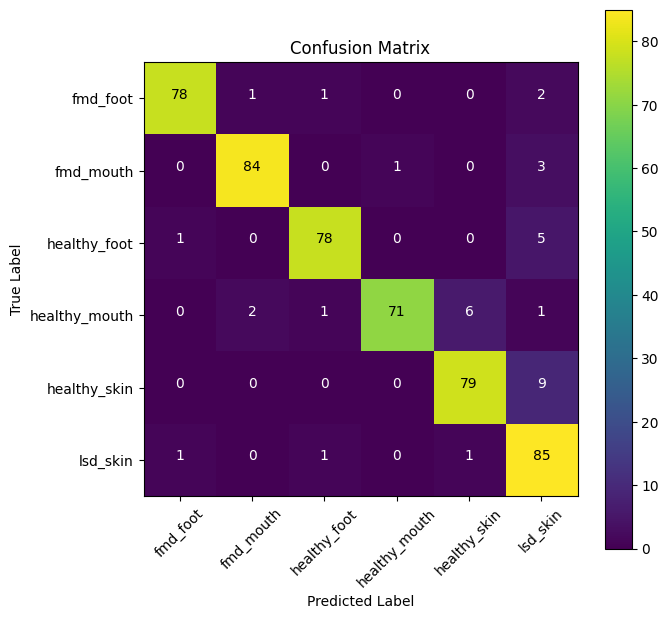

In [22]:
# Inception model classification report
clf_report(true_value, inception_pred)

In [23]:
true_value = []
combined_model_pred = []

for folder in os.listdir(seg_test_folders):
    test_image_ids = os.listdir(os.path.join(seg_test_folders, folder))

    for image_id in test_image_ids[:int(len(test_image_ids))]:
        path = os.path.join(seg_test_folders, folder, image_id)

        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path), (150, 150))
        img_normalized = img / 255

        # VGG
        vgg16_image_prediction = np.argmax(vgg_best_model.predict(np.array([img_normalized])))

        # ResNet50
        #resnet_50_image_prediction = np.argmax(resnet_best_model.predict(np.array([img_normalized])))

        # Inception
        inception_image_prediction = np.argmax(inception_best_model.predict(np.array([img_normalized])))

        # Combine Predictions (Majority Vote)
        #combined_prediction = mode([vgg16_image_prediction, resnet_50_image_prediction, inception_image_prediction])[0]
        combined_prediction = mode([vgg16_image_prediction, inception_image_prediction])[0]
        combined_model_pred.append(combined_prediction)


1/1 [==============================] - 0s 41ms/step


In [24]:
combined_accuracy = np.sum(np.array(true_value) == np.array(combined_model_pred)) / len(true_value)
print('Combined Model Accuracy:', combined_accuracy)


Combined Model Accuracy: 0.7886497064579256


Combined Model Accuracy: 0.7886497064579256


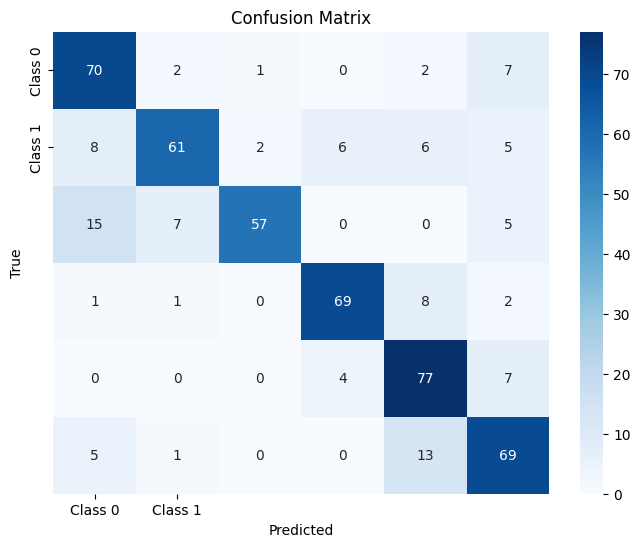

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss

# Assuming you have true labels and predictions
# Replace this with your actual data
true_labels = np.array(true_value)
predicted_labels = np.array(combined_model_pred)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print('Combined Model Accuracy:', accuracy)

# Assuming you have a binary classification problem
# If you have a multi-class problem, adjust accordingly
# loss = log_loss(true_labels, predicted_labels)
# print('Combined Model Loss:', loss)

# Plot a confusion matrix (for classification problems)
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


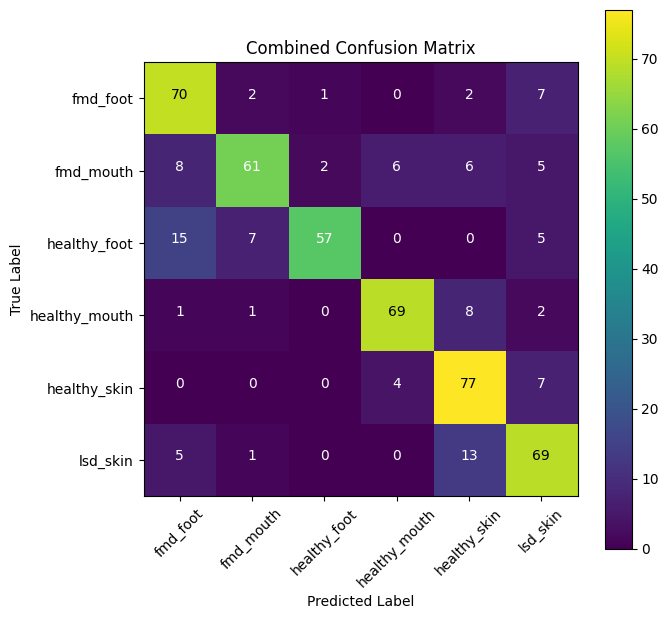

In [31]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

def plot_combined_confusion_matrix(true_value, model_pred):
    classes = validation_generator.class_indices.keys()

    plt.figure(figsize=(7, 7))
    cm = confusion_matrix(true_value, model_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.viridis)
    plt.title('Combined Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() * 0.8
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Call the function with true labels and combined predictions
plot_combined_confusion_matrix(true_value, combined_model_pred)


Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.85      0.77        82
           1       0.85      0.69      0.76        88
           2       0.95      0.68      0.79        84
           3       0.87      0.85      0.86        81
           4       0.73      0.88      0.79        88
           5       0.73      0.78      0.75        88

    accuracy                           0.79       511
   macro avg       0.81      0.79      0.79       511
weighted avg       0.80      0.79      0.79       511



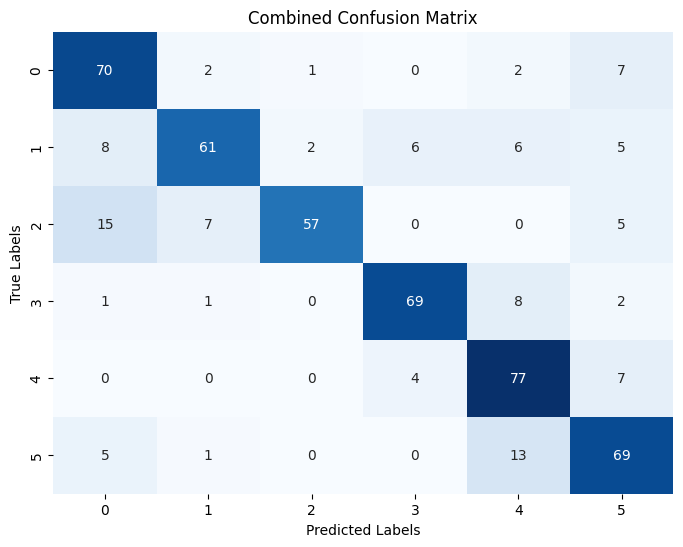

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming true_value and combined_model_pred are your true labels and predicted labels
# Generate the classification report
report = classification_report(true_value, combined_model_pred)

# Print the classification report
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(true_value, combined_model_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Combined Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#combine vgg16,inceptionv3
